In [2]:
import nltk
import numpy as np
import pandas as pd

# Data preparation

In [127]:
data = pd.read_csv('./overhear_data.tsv', sep='\t')
data['date'] = pd.to_datetime(data['date'])

In [128]:
data.head(3)

,text,date,likes,comments,reposts
0,"Болел. Температурил. Ныл. Шепчу в шутку: ""Я по...",2017-05-02 17:40:00,21835,104,0
1,"Ребят, а мы есть в Telegram 😉 Подслушано — ...",2017-05-03 21:40:00,38,0,0
2,Собралась к своему молодому человеку на ночь. ...,2017-05-03 21:30:00,4007,10,0


In [129]:
data.dtypes

text                object
date        datetime64[ns]
likes                int64
comments             int64
reposts              int64
dtype: object

In [138]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_month'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek
data['hour_in_week'] = data['day_of_week'] * 24 + data['date'].dt.hour

In [139]:
data.head(3)

,text,date,likes,comments,reposts,year,month,day_of_month,day_of_week,hour_in_week
0,"Болел. Температурил. Ныл. Шепчу в шутку: ""Я по...",2017-05-02 17:40:00,21835,104,0,2017,5,2,1,41
1,"Ребят, а мы есть в Telegram 😉 Подслушано — ...",2017-05-03 21:40:00,38,0,0,2017,5,3,2,69
2,Собралась к своему молодому человеку на ночь. ...,2017-05-03 21:30:00,4007,10,0,2017,5,3,2,69


In [164]:
from sklearn.metrics import mean_squared_error

def loss(real, pred):
    """Squared loss from vowpal wabbit"""
    return mean_squared_error(real, pred) / 2.

baseline_pred = data['likes'].mean()
mse_error = loss(data['likes'], [baseline_pred] * data.shape[0])
print('baseline: {}'.format(mse_error))

baseline: 59652846.0439319


In [161]:
def mse(real, pred):
    return np.mean((real - pred)**2)
rmse(data['likes'], [baseline_pred] * data.shape[0])

119305692.08786353

In [151]:
mean_squared_error(data['likes'], [baseline_pred] * data.shape[0])
119305692.0878638
59652846.04393177

119305692.0878638

## Plots

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

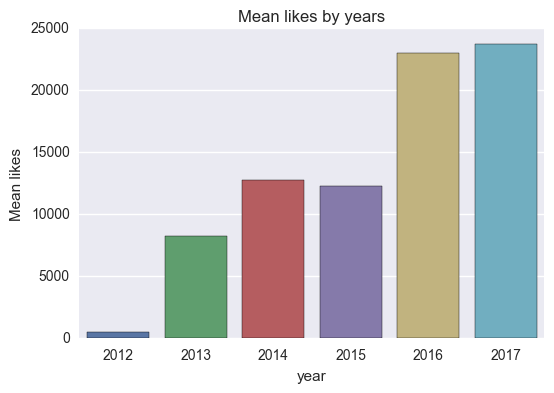

In [141]:
d = data.groupby(['year'])['likes'].mean()#.plot(kind='bar')
sns.barplot(d.index, d.values)
plt.title('Mean likes by years')
plt.ylabel('Mean likes')
plt.show()

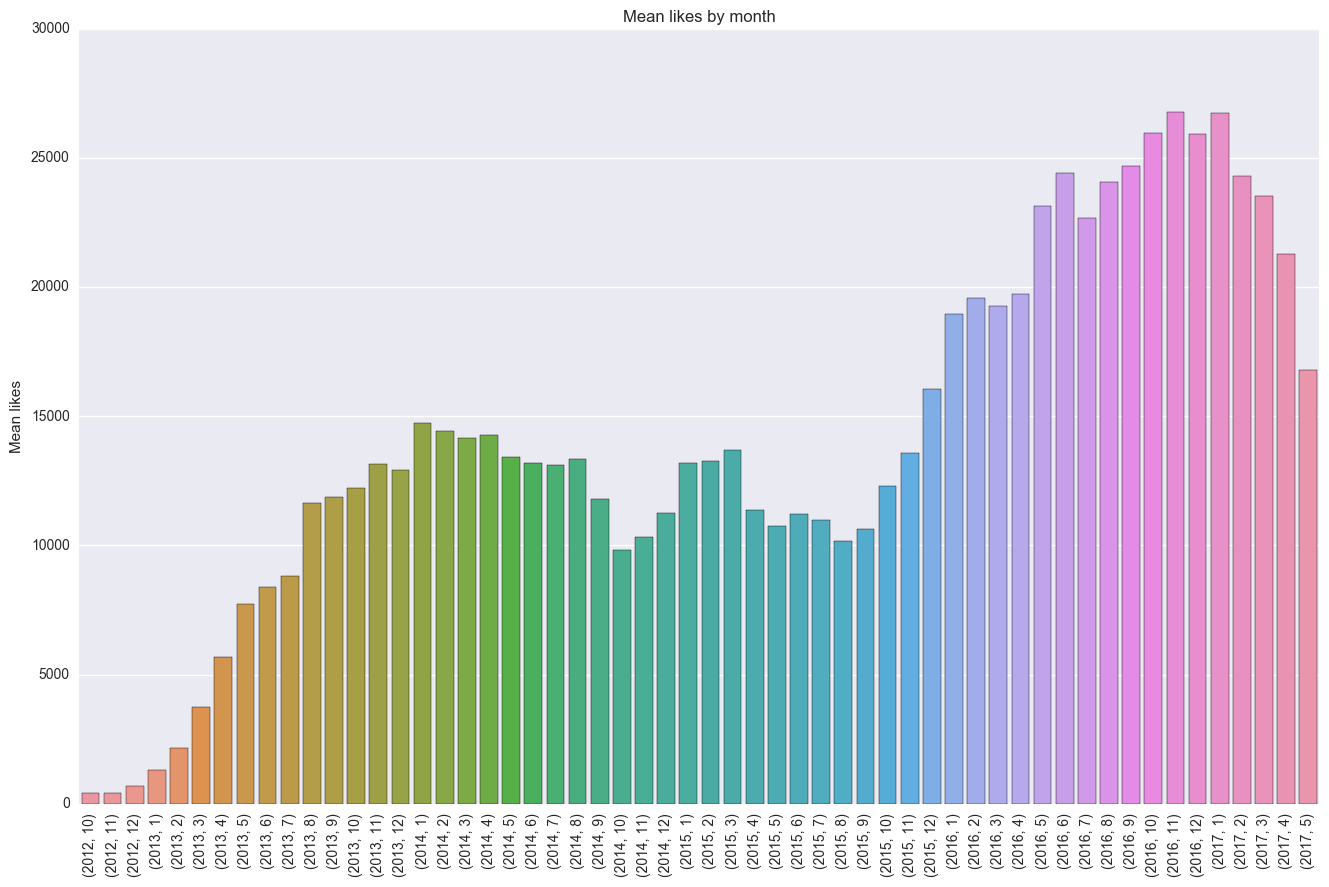

In [142]:
d = data.groupby(['year', 'month'])['likes'].mean()
plt.figure(figsize=(16,10))
sns.barplot(x=d.index, y=d.values)
plt.xticks(rotation=90)
plt.title('Mean likes by month'.format(year))
plt.ylabel('Mean likes')
plt.show()

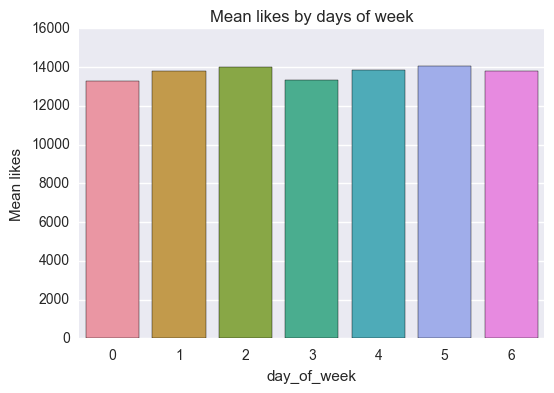

In [143]:
d = data.groupby(['day_of_week'])['likes'].mean()
sns.barplot(d.index, d.values)
plt.title('Mean likes by days of week')
plt.ylabel('Mean likes')
plt.show()

## Utils

In [166]:
import string

# print 
translator = str.maketrans('', '', string.punctuation)

def save_for_vw(df, filename):
    with open(filename, 'w+', encoding='utf-8') as f:
        for index, row in df.iterrows():
            text = row['text']
            # todo: use translate
            # todo: remove stopwords
            # todo: use stemming
            text = text.lower().translate(translator).replace(':', '').replace('|', '').replace('\n','').replace('(', '').replace(')', '')
            f.write('{0} | {1} | {2} | {3} | {4} | {5}\n'.format(row['likes'], text, row['year'], row['month'],
                                                            row['day_of_month'], row['hour_in_week']))

save_for_vw(data, 'test_data.vw')

In [ ]:
!vw -d test_data.vw -f linear_model -c --loss_function squared -b 28 --ngram=2 --random_seed=17 --passes=100 --cache_file cache.cache -p pred.txt
!vw -d test_data.vw -f linear_model -c --loss_function squared -b 28 --rando
m_seed=17 --passes=100 --cache_file cache.cache -p pred.txt --l2 0.0000005 -q ee

## Test stuff

In [11]:
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import RussianStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
def tokenize(text):
    rus_stemmer = RussianStemmer()
    text = text.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    tokens = ' '.join(tokens)
    return rus_stemmer.stem(tokens)

In [13]:
tokenized_texts = data['text'].apply(tokenize)

In [40]:
count_vectorizer = CountVectorizer(min_df=5)
bag_of_words = count_vectorizer.fit_transform(tokenized_texts)

In [27]:
t = ['это тест', 'и еще один']
count_vectorizer.fit_transform(t).toarray()

array([[0, 0, 1, 1],
       [1, 1, 0, 0]], dtype=int64)

In [41]:
bag_of_words.shape

(42887, 16701)

In [46]:
train_ind = int(data.shape[0] * 0.8)

In [52]:
lr = LinearRegression(n_jobs=-1)

In [53]:
lr.fit(bag_of_words[:train_ind], data['likes'][:train_ind])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [50]:
lr.score(bag_of_words[:train_ind], data['likes'][:train_ind])

0.81870651908177883

In [54]:
lr.score(bag_of_words[train_ind:], data['likes'][train_ind:])

-10.093546101778317

In [56]:
from sklearn.model_selection import cross_val_score

In [57]:
lr_cv = cross_val_score(lr, bag_of_words[:train_ind], data['likes'][:train_ind],
                n_jobs=-1, cv=5).mean()

In [61]:
np.sqrt(np.sum((data['likes'][train_ind:] -
                np.mean(data['likes'][train_ind:])) ** 2 /
               len(data['likes'][train_ind:])))

25.032884657163496

In [62]:
from sklearn.linear_model import ElasticNet

In [63]:
X_train, y_train = bag_of_words[:train_ind], data['likes'][:train_ind]
X_test, y_test = bag_of_words[train_ind:], data['likes'][train_ind:]

In [65]:
enet = ElasticNet(random_state=42, )
enet.fit(X_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.0001, warm_start=False)

In [66]:
enet.score(X_train, y_train)

0.25816144013201103

In [67]:
enet.score(X_test, y_test)

-0.81543395156641041

In [69]:
from sklearn.metrics import mean_squared_error

In [70]:
mean_squared_error(y_test, enet.predict(X_test))

1137.6331790954923

In [71]:
mean_squared_error(y_train, enet.predict(X_train))

3116.6371961132527

In [72]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
enet = ElasticNet(normalize=True, )
param_dist = {"alpha": [0.0, 0.5, 1.0],
              "l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0],
              "tol": [0.00001, 0.001, 0.1, 1]}

model = RandomizedSearchCV(enet, param_distributions=param_dist,
                          n_iter=30, verbose=1, random_state=42)

model.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


D:\soft\dev\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
